
# AI Corpus Data Explorer

Explore the harvested consultation corpus. This notebook inspects the folder structure, connector coverage, download/extraction health, and the normalized records used by the application.


## Setup & Paths

All harvested content resides in `data/comments/`, while downstream application assets live in `data/app_data/`. Update the cell below if the repository layout changes.

**Key formats**

- `*.meta.jsonl` (produced by `crawl`): one JSON object per line, mirroring the `DocMeta` fields for a collection. Files sit under `data/comments/<connector>/<collection>/<collection>.meta.jsonl`.

- `data/comments/ai_pipeline.sqlite` (download cache): `downloads` table stores one row per fetched document/bundle with `doc_id`, `connector`, `collection_id`, `payload` (JSON), and optional `text_path`/`sha256_text` columns.
 
- `data/comments/blobs/` (content-addressed text store): each text artefact is written once as `<sha256>.txt`; connectors (e.g., CPPA letters) and the generic `extract` stage reuse this location.
 
- `data/app_data/ai_corpus.db` (normalized corpus): `documents` table contains the application-facing view. CPPA bundle letters appear here with doc IDs like `part4_all_comments...pdf#L007`, referencing the blob-backed text path.


In [140]:
from utils import show_text_diff

In [2]:
import re
import pyperclip

from prompt_utils import (
    async_client,
    sync_client,
    process_batch,
    process_one,
    CLEANER_PROMPT,
    ANALYSIS_PROMPT,
    AI_PROMPT,
    ARGUMENTATION_PROMPT,
)

from reader_utils import load_api_key

load_api_key("/Users/spangher/.openai-reglab-project-key.txt")


In [ ]:
%load_ext autoreload
%autoreload 2

In [442]:
from clustering_utils import (
    embed_arguments,
    evaluate_kmeans,
    assign_kmeans_clusters,
    setup_argument_records,
    run_umap_bgmm,
    summarize_bgmm,
    build_contrast_pairs,
)
import prompt_utils as p

In [ ]:
from pathlib import Path
import json
import sqlite3
import itertools
import pandas as pd
import numpy as np

from reader_utils import (
    resolve_project_root,
    get_project_paths,
    connect_export_db,
    load_text_df,
    merge_label_results,
    read_text_blob,
)

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 160)

PROJECT_ROOT = resolve_project_root()
PATHS = get_project_paths(PROJECT_ROOT)
COMMENTS_ROOT = PATHS['comments_root']
APP_DATA_ROOT = PATHS['app_data_root']
DOWNLOAD_DB_PATH = PATHS['download_db_path']
EXPORT_DB_PATH = PATHS['export_db_path']

print(f'Project root : {PROJECT_ROOT}')
print(f'Comments root: {COMMENTS_ROOT}')
print(f'App data root: {APP_DATA_ROOT}')
print(f'Download DB  : {DOWNLOAD_DB_PATH}')
print(f'Export DB    : {EXPORT_DB_PATH}')

text_df = load_text_df(EXPORT_DB_PATH, PROJECT_ROOT)
text_df['source'].value_counts()

In [5]:
source_sql = """
    SELECT
          source,
          collection_id,
          COUNT(*) AS documents,
          SUM(CASE WHEN text_path IS NOT NULL THEN 1 ELSE 0 END) AS docs_with_text,
          SUM(CASE WHEN pdf_path IS NOT NULL THEN 1 ELSE 0 END) AS docs_with_pdf
      FROM documents
      GROUP BY source, collection_id
      HAVING COUNT(*) > 10
      ORDER BY documents DESC;
"""
source_summary = pd.read_sql(source_sql, export_conn)
source_summary

,source,collection_id,documents,docs_with_text,docs_with_pdf
0,regulations_gov,NTIA-2023-0005,1452,1452,274
1,cppa_admt,PR-02-2023,592,592,592
2,eu_have_your_say_playwright,_info_law_better-regulation_have-your-say_init...,438,438,0
3,regulations_gov,NTIA-2023-0009,335,335,121
4,regulations_gov,OMB-2023-0020,197,197,146
5,nist_airmf,AI-RMF-2ND-DRAFT-2022,85,85,84
6,hand_curated_responses,uk_ai_regulation_responses,31,31,15


# Affiliation of the commenter

In [ ]:
text_df = pd.read_csv('processed_dataset.csv', index_col=0).reset_index(drop=True)
text = text_df['clean_text'].iloc[4]
test_batch = await process_batch(text_df['clean_text'], ANALYSIS_PROMPT, concurrency=500)

In [778]:
top_collections = text_df['collection_id'].value_counts().loc[lambda s: s > 1].index

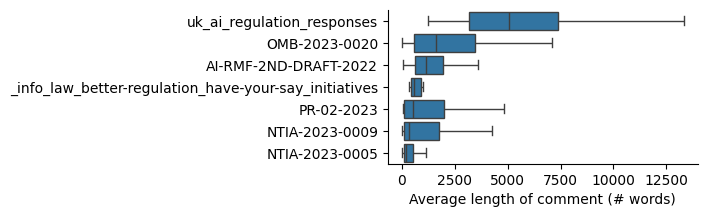

In [779]:
f, ax = plt.subplots(1, 1, figsize=(4,2))
(text_df
 .loc[lambda df: df['collection_id'].isin(top_collections)]
 .assign(text_len=lambda df: df['text'].str.split().str.len())
 .pipe(lambda df: 
       sns.boxplot(
           data=df, 
           x='text_len', 
           y='collection_id', 
           order=df.groupby('collection_id')['text_len'].median().sort_values(ascending=False).index,
           showfliers=False
       ),
      ) 
)
ax.set_ylabel('')
ax.set_xlabel('Average length of comment (# words)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
test_batch_parsed = list(map(json.loads, test_batch))
text_df_with_labels = merge_label_results(text_df, test_batch_parsed)

In [ ]:
comment_counts = text_df_with_labels['label'].value_counts()
top_orgs = comment_counts.head(15).index.tolist()

In [641]:
import seaborn as sns

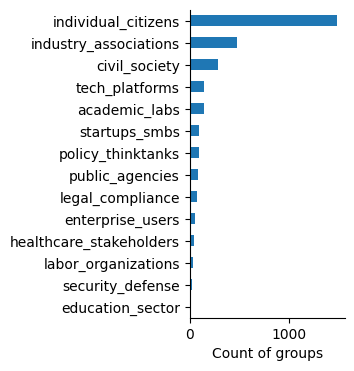

In [599]:
ax = (
    argument_records
     .drop_duplicates('doc_id')['label']
     .value_counts()
     .loc[lambda s: s > 10].iloc[::-1].plot(kind='barh', figsize=(2,4))
)
plt.ylabel('')
plt.xlabel('Count of groups')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

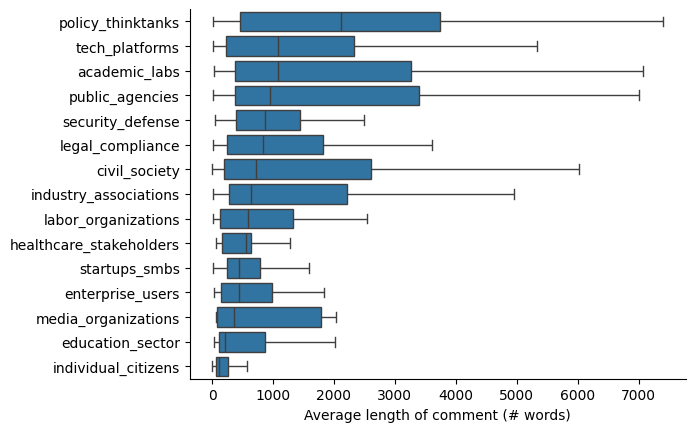

In [675]:
ax = (
    text_df_with_labels
         .assign(text_len=lambda df: df['clean_text'].str.split().str.len())
         .loc[lambda df: df['label'].isin(top_orgs)]
         .pipe(lambda df: 
               sns.boxplot(
                   data=df, 
                   x='text_len', 
                   y='label', 
                   order=df.groupby('label')['text_len'].median().sort_values(ascending=False).index,
                   showfliers=False
               ),
              )
)
ax.set_ylabel('')
ax.set_xlabel('Average length of comment (# words)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Is about AI

In [141]:
test_one = process_one(text_df["clean_text"].iloc[0], AI_PROMPT)
test_one

'Yes — the comment responds to proposed California regulations governing automated decisionmaking technologies (ADMT) and AI-related activity, addressing definitions, pre-use notices, opt-outs, access rights, risk assessments, and calls for harmonization with other AI laws and regulators.'

# Argumentation

In [ ]:
argumentation_batch = await process_batch(text_df["clean_text"].tolist(), ARGUMENTATION_PROMPT, concurrency=500)
text_df['arguments'] = argumentation_batch

In [543]:
SNIPPET_PROMPT = """You are an expert policy analyst. You will receive a policy comment and a list of {k} arguments drawn from that
  comment. For each argument:

  - Find 1-2 snippets copied from the comment that BEST support it.
  - Copy the snippets verbatim (no edits, no paraphrasing).
  - If you find >1 snippets, join them with a single newline (\n).

  Format your response as follows:

  1. Snippets corresponding to each argument are numbered (1., 2., …).
  2. Separate numbered entries with \n\n.
  3. Do not insert or copy over blank lines anywhere else.
  <comment text>
  {comment_text}
  </comment text>
  <arguments>
  {arguments}
  </arguments>
"""

In [544]:
args_formatted = (
    text_df['arguments']
        .str.split('\n\n').apply(lambda x: list(map(lambda y: f"{y[0] + 1}: {y[1]}", enumerate(x))))
)
k = args_formatted.str.len()
args_formatted = args_formatted.str.join('\n')

In [545]:
prompts = list(map(
    lambda x: SNIPPET_PROMPT.format(k=x[2], arguments=x[1], comment_text=x[0]), 
    zip(text_df['clean_text'].tolist(), args_formatted.tolist(), k.tolist())
))

In [ ]:
snippets = await p.process_batch(prompts=prompts, check_additional=[p.numbered_list_checker], max_attempts=10)

In [553]:
text_df['snippets'] = snippets

In [554]:
text_df.to_csv('processed_dataset.csv')

### Clustering comments

In [695]:
argument_records = setup_argument_records(text_df, text_df_with_labels)
# argument_records, sampled_indices = downsample_argument_records(argument_records, max_samples=5000, random_state=42)
# print(f"Using {len(argument_records)} arguments (downsampled from {len(argument_records)})")

snippet_exploded = (
    text_df[['doc_id', 'snippets']]
         .assign(snippets=lambda df: df['snippets'].str.split('\n\n'))
         .explode('snippets')
         .assign(snippet_num_in_doc=
                 lambda df: df['snippets'].str.strip()
                                 .str.split()
                                 .str.get(0).str.replace('.', '')
                                 .apply(lambda x: int(x) if (pd.notnull(x) and x.isdigit() ) else None)
                )
         .dropna()
         .assign(snippet_num_in_doc=lambda df: df['snippet_num_in_doc'].astype(int))
)

argument_records['arg_num_in_doc'] = argument_records.groupby('doc_id')['argument_id'].rank(method='dense').astype(int)
argument_records = argument_records.merge(
    snippet_exploded, left_on=['doc_id', 'arg_num_in_doc'], right_on=['doc_id', 'snippet_num_in_doc'], how='left'
)
argument_records['snippets'] = argument_records['snippets'].str.replace(r'^\d+\.', '', regex=True)

Text(0.5, 0, 'Count of arguments in comment')

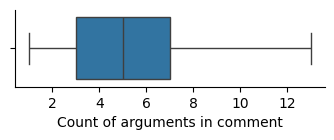

In [804]:
f, ax = plt.subplots(1, 1, figsize=(4,1))
sns.boxplot(x=argument_records['doc_id'].value_counts(), showfliers=False, ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Count of arguments in comment')

In [783]:
t = argument_records[['argument', 'snippets']].sample(5)

In [788]:
t.iloc[1:][['snippets', 'argument']].assign(snippets=lambda df:  '...' + df['snippets'] + '...').rename(columns={'snippets': 'snippet of comment'})

,snippet of comment,argument
9488,... AI companies use art assets without artists' permission in order to replicate their work for free.\nIt's nothing more than an elaborate form of plagiarism that attempts to obscure the identities of the victims by collaging pieces together....,"Unauthorized appropriation / copyright theft: AI systems train on and reproduce artists' work without permission, which is framed as plagiarism or theft."
10677,"... Any effective AI accountability system must include companies disclosing the training data used, especially copyrighted training data, to trail ML models.\nPlease require and enforce disclosure, as other responsible governments appear to be d...","Transparency/Accountability: Argues that companies should be required to disclose training data so regulators and the public can audit, trace, and hold AI developers accountable."
5500,"... If a government or organization may wish to create a new impact assessment, it is advised that the assessment capture risk, cover the entire lifecycle, operate in a multistakeholder fashion, and assist with go/no-go decisions.\n“This program ...","Procedural, risk‑based preference: Favors flexible, impact‑assessment driven processes over prescriptive, sector‑specific regulation."
241,"... They need clear, thoughtful mies that consider their needs and limitations, as well as how they use digital tools to keep their businesses thriving.\nWe urge the CPPA to more carefully consider the impact and costs of the proposed regulations...","Proportionality/tailoring plea: Calls for balanced, scaled regulations that consider small business capacities and avoid one-size-fits-all mandates."


In [ ]:
argument_embeddings = embed_arguments(argument_records["argument"].tolist(), sync_client)
from umap import UMAP
umap_model = UMAP(n_components=15, metric="cosine", min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(argument_embeddings)

In [ ]:
max_k = max(3, min(25, len(argument_records)))
k_values = range(2, max_k)
kmeans_eval = evaluate_kmeans(umap_embeddings, k_values)
kmeans_eval

In [ ]:
best_kmeans = kmeans_eval.attrs.get("best_model")
if best_kmeans is None:
    raise RuntimeError("No best KMeans model found. Check kmeans_eval.")
cluster_summary, representatives = assign_kmeans_clusters(argument_records, umap_embeddings, best_kmeans)
cluster_summary.head(10)

In [ ]:
reduced_embeddings, bgmm_labels, bgmm_probs, bgmm_silhouette = run_umap_bgmm(
    argument_embeddings,
    n_components=min(80, len(argument_records)),
    umap_kwargs={"n_components": 15, "metric": "cosine", "min_dist": 0.1},
    weight_concentration_prior=0.1,
)

In [715]:
bgmm_summary = summarize_bgmm(argument_records, argument_records['bgmm_cluster'], argument_records['bgmm_posterior'])
print(f"BGMM silhouette (UMAP space): {bgmm_silhouette:.4f}")

BGMM silhouette (UMAP space): 0.3655


In [707]:
argument_records['bgmm_cluster'] = bgmm_labels
argument_records['bgmm_posterior'] = bgmm_probs

### summarizing comments

In [710]:
SUMMARIZATION_PROMPT = """You are an expert policy analyst summarizing statements about AI legislation.
I will give you a set of descriptions, that I clustered because they represented the same topic.
Please output a single, concise summary (one-sentence), emphasizing keywords and condensing the descriptions (~20 words).

<descriptions>
{input_text}
</descriptions>
"""

SHORT_SUMMARIZATION_PROMPT = """You are an expert policy analyst summarizing statements about AI legislation.
I will give you a set of descriptions, that I clustered because they represented the same topic.
Please output a single, VERY concise keyword summary (1-3 words), condensing the descriptions.

<descriptions>
{input_text}
</descriptions>
"""

cluster_records = (
    argument_records
         .groupby('bgmm_cluster')
         .apply(lambda df: df.sort_values('bgmm_posterior', ascending=False).head(10)['argument'])
         .groupby(level=0)
         .aggregate(list)
)

cluster_summaries = await process_batch(cluster_records.str.join('\n').tolist(), SUMMARIZATION_PROMPT)
cluster_summaries = pd.Series(cluster_summaries, index=cluster_records.index)

keyword_cluster_summaries = await process_batch(cluster_records.str.join('\n').tolist(), SHORT_SUMMARIZATION_PROMPT)
keyword_cluster_summaries = pd.Series(keyword_cluster_summaries, index=cluster_records.index)

cluster_summary_concat = pd.concat([keyword_cluster_summaries.to_frame('keyword'), cluster_summaries.to_frame('summary')], axis=1)

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_1255/744081245.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values('bgmm_posterior', ascending=False).head(10)['argument'])


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [712]:
cluster_samples = (
    argument_records
         .groupby('bgmm_cluster')
         .apply(lambda df: df.sort_values('bgmm_posterior', ascending=False).head()[['argument', 'snippets', 'label']])
).reset_index().drop(columns='level_1')

top_arguments_by_cluster = cluster_samples.groupby('bgmm_cluster')[['argument', 'snippets']].aggregate(list)

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_1255/3439075035.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values('bgmm_posterior', ascending=False).head()[['argument', 'snippets', 'label']])


In [806]:
cluster_summary_concat.head(10)

,keyword,summary
bgmm_cluster,,
0,Enforcement authority,"Mandate firm benefit–risk documentation and give regulators statutory duties plus authority to review, challenge, and prohibit harmful AI processing."
1,Labor protections,"Require labor protections for moderators, annotators, crowdworkers (including volunteers), with mental‑health safeguards, fair pay, supply‑chain accountability, safe working conditions."
2,Staged access,"Advocate staged, tiered, or structured access (APIs, vetted research access) as a middle path—recognizing weight-release irreversibility and leakage risks."
3,Technological inevitability,"Argues AI's technological inevitability and ubiquity make strict regulation futile, risking innovation chill, industry/talent flight, and economic competitiveness loss."
4,Regulatory duplication,"Warns the proposal duplicates NAIC, NIST/ISO, and statutory frameworks prematurely, creating overlapping audits, inconsistent definitions, and unnecessary compliance burdens."
5,Youth protections,"Require heightened protections for minors and vulnerable populations: age-based safeguards, sensitive-data rules, parental consent, and provider responsibility against AI harms."
6,Risk-proportionality,"Adopt a risk‑based, proportional regulatory approach: scale obligations to system risk, context, and resources—lighter for low‑risk, stricter for high‑risk."
7,Consent and Compensation,"Mandate explicit CONSENT and FAIR COMPENSATION for creators whose works train AI, with opt‑in licensing and removal rights."
8,Expert authority,"Urges policymakers to consult AI experts and institutions (e.g., IEEE), relying on expert consensus to legitimize urgent, safety-focused regulation."


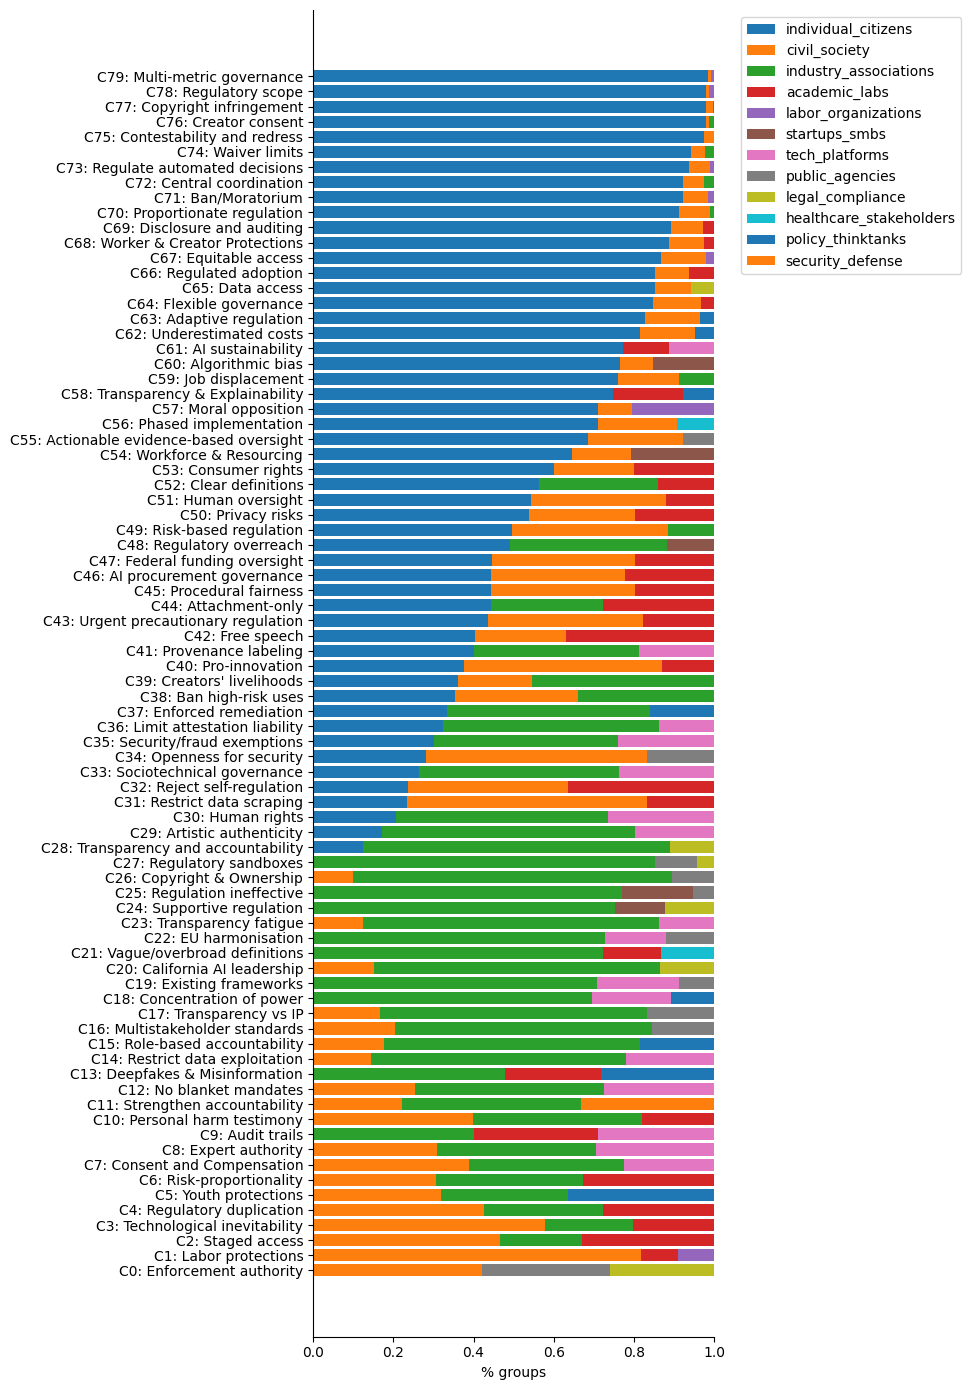

In [719]:
cluster_identity_distribution = (
    bgmm_summary['dominant_labels']
        .apply(pd.Series).fillna(0).pipe(lambda df: df.divide(df.sum(axis=1), axis=0)).sort_index()
        .sort_values(['individual_citizens', 'industry_associations']).copy()
)

labels = (
    keyword_cluster_summaries
        .to_frame('keyword')
        .reset_index().rename(columns={'bgmm_cluster': 'cluster'})
        .apply(lambda x: f"C{x['cluster']}: {x['keyword']}", axis=1)
)

fig, ax = plt.subplots(figsize=(10, 14))
left = np.zeros(len(cluster_identity_distribution))

for column in cluster_identity_distribution.columns:
    ax.barh(
        labels,
        cluster_identity_distribution[column],
        left=left,
        label=column,
    )
    left += cluster_identity_distribution[column]

ax.set_xlabel("% groups")
ax.set_xlim(0, 1)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [720]:
import clustering_utils as c
cluster_idx, distances = c.cluster_centroid_distance_matrix(argument_embeddings, argument_records['bgmm_cluster'].tolist())

In [721]:
cluster_diff_df = pd.DataFrame(distances, index=cluster_idx, columns=cluster_idx)
cluster_diff_df = (
    cluster_diff_df
        .pipe(lambda df: pd.DataFrame(np.triu(df), index=df.index, columns=df.columns))
        .unstack()
        .sort_values(ascending=False)
        .to_frame('distance')
        .reset_index()
        .rename(columns={'level_0': 'cluster_0', 'level_1': 'cluster_1'})
        .loc[lambda df: df['distance'] > 0]
)

In [722]:
cluster_diff_df_w_summaries = (
    cluster_diff_df
         .merge(top_arguments_by_cluster.rename(columns=lambda x: x + '_0'), left_on='cluster_0', right_index=True)
         .merge(top_arguments_by_cluster.rename(columns=lambda x: x + '_1'), left_on='cluster_1', right_index=True)
)

In [723]:
input_text = (
    cluster_diff_df_w_labels_and_summs
        .apply(lambda x: 
   """<statement 1>
{statements_1}
</statement 1>
   
<statement 2>
{statements_2}
</statement 2>""".format(
          statements_1=f"{x['keyword_0']}: {x['summary_0']}",
          statements_2=f"{x['keyword_1']}: {x['summary_1']}",
      ), axis=1)
    )

In [819]:
CONTRAST_PROMPT = """You are an expert policy analyst comparing two sets of statements about AI legislation.
We picked these arguments to be different, but we're not sure if they are relevant to each other.
Determine whether the statements agree, disagree, or are neutral.

* "agree" is when two stances support each other or argue for the same goal.
* "disagree" is when two stances are on the same issue, directly contrast with each other, and argue for opposite goals.
* "neutral" is when two stances are not relevant to each other.

Respond with JSON {{"label": "...", "reason": "..."}} where label is one of ["disagreement", "agreement", "neutral"].

{input_text}
"""
# contrast_outputs = await process_batch(pair_inputs, prompt=CONTRAST_PROMPT, concurrency=8, check_json=True)
# contrast_results = pd.DataFrame([{**meta, **json.loads(output)} for meta, output in zip(pair_metadata, contrast_outputs)]).sort_values("distance", ascending=False)
# contrast_results.head()


In [820]:
contrast_outputs = await p.process_batch(input_text.tolist(), CONTRAST_PROMPT, concurrency=500, check_json=True, model='gpt-5')

  0%|          | 0/1128 [00:00<?, ?it/s]

In [821]:
contrast_outputs = list(map(json.loads, contrast_outputs))

In [822]:
contrast_outputs_df = pd.DataFrame(contrast_outputs)

In [823]:
contrast_outputs_df['label'].value_counts()

label
neutral         631
agreement       403
disagreement     94
Name: count, dtype: int64

In [825]:
cluster_diff_df_w_labels = pd.concat([cluster_diff_df_w_summaries, contrast_outputs_df], axis=1)

In [826]:
cluster_diff_df_w_labels_and_summs = (
    cluster_diff_df_w_labels
         .merge(keyword_cluster_summaries.to_frame('keyword_0'), left_on='cluster_0', right_index=True)
         .merge(keyword_cluster_summaries.to_frame('keyword_1'), left_on='cluster_1', right_index=True)
         .merge(cluster_summaries.to_frame('summary_0'),  left_on='cluster_0', right_index=True)
         .merge(cluster_summaries.to_frame('summary_1'),  left_on='cluster_1', right_index=True)
)

In [827]:
pd.options.display.max_colwidth = 250

In [828]:
cluster_disagreement_samples = (
    cluster_diff_df_w_labels_and_summs
         .loc[lambda df: df['label'] == 'disagreement']
         [['reason','keyword_0', 'summary_0', 'snippets_0', 'keyword_1', 'summary_1', 'snippets_1']]
         .head(5)
)

In [843]:
for _, row in cluster_disagreement_samples.iterrows():
    row
    print(f"""
{row['keyword_0']}: {row['summary_0']}

    <disagrees with>

{row['keyword_1']}: {row['summary_1']}

Reason: 
{row['reason']}

Examples Statement 1: 
{'...' + '...\n...'.join(row['snippets_0'][:3]) + '...'}

Examples Statement 2:
{'...' + '...\n...'.join(row['snippets_1'][:3]) + '...'}
    """)

    print('\n===============================================================\n')



Creators' livelihoods: Unlicensed AI training on artists’ work threatens livelihoods and copyrights, enabling large companies’ economic exploitation and concentrating profits, harming small creators.

    <disagrees with>

Regulatory sandboxes: Promote regulatory sandboxes and flexible, case-by-case, voluntary governance to foster SME‑accessible innovation, fair transparent access, and risk‑managed R&D.

Reason: 
Statement 1 advocates protecting IP within AI legislation and favors a non‑prescriptive approach, while Statement 2 seeks to strip IP rights from AI-generated outputs (public domain) and bar commercialization. These positions conflict on the treatment of IP in AI.

Examples Statement 1: 
... are now using artists stolen life works to steal their livelihood for the rest of their lives and also rob future generations of potential artists that won’t be able to afford to pursue art because the industry is ruined.
millions and millions of coders, artists, writers, musicians, journ

In [813]:
row

reason        Statement 1 seeks prescriptive, mandatory measures (opt-in licensing, compensation, strengthened IP rules) for AI training/use, while Statement 2 advocates light-touch, non‑prescriptive, low‑burden regulation to protect innovation. These position...
keyword_0                                                                                                                                                                                                                                               Attachment-only
summary_0                                                                                   Attachment-only administrative submissions: commenters reference attached feedback but provide no substantive arguments on AI legislation, leaving positions indeterminate.
snippets_0    [ see attached file\nEN (321.6 KB - PDF - 1 page) Download,  Please see attached document.\n(333.8 KB - PDF - 1 page),  Feedback from: Center for Data Innovation\nThe Center for Data Innovation 

# Calculate cluster co-occurrence in a document

In [739]:
import clustering_utils as c
reload(c)

<module 'clustering_utils' from '/Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/notebooks/clustering_utils.py'>

In [759]:
G = c.compute_cluster_cooccurrence_graph(
    argument_records,
    cluster_col="bgmm_cluster",   # or "bgmm_cluster" if you want GMM groupings
    doc_col="doc_id",
    min_weight=5.0,          # only keep edges with lift > 1
    weight_metric="lift",    # or "count" for raw co-occurrence
)

In [760]:
from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(G, weight="weight")

In [764]:
for i, c in enumerate(list(filter(lambda x: len(x) > 2, communities))):
    print(f'==============Community {i+1}==============')
    print()
    for c_i in c:
        print('  * ' + cluster_summary_concat.apply(lambda x: f"{x['keyword']}: {x['summary']}", axis=1).iloc[c_i - 1])
    print()
    print()

==============Community 1==============

  * Adaptive regulation: Mandate adaptive, iterative regulation—regular reviews/updates, formal mechanisms (including public input) to swiftly address evolving AI capabilities, risks, and uncertainty.
  * Flexible governance: Advocate flexible, scalable, tailored federal AI governance—avoiding sectoral fragmentation, leveraging existing accreditation, adaptable CAIO roles, and learning-by-doing.
  * Reject self-regulation: Rejects industry self-regulation, demanding mandatory enforceable laws and expert regulators to ensure accountability, curb profit-driven abuse, and protect copyright.
  * Data access: Ensure government‑facilitated, secure/anonymized access to large, high‑quality, representative datasets and aligned IP/data policies (EU/UK/Open Science) to enable safe, competitive AI.
  * Enforced remediation: Require strict enforcement—penalties and retroactive remedies (forced deletion/retraining, detection tools) for models trained on unaut

In [153]:
distinct_responses = list(set(responses))
show_text_diff(distinct_responses[0], distinct_responses[1])
show_text_diff(distinct_responses[1], distinct_responses[2])
show_text_diff(distinct_responses[0], distinct_responses[2])

Text A,Text B
"Feedback from: gauthier lasou A European regulation that will set out ethical and legal requirements for AI usage in Europe. written in English, 108 pages + annexes, impact studies, etc. To my knowledge, you are addressing European citizens who do not all understand English, especially when a specific jargon is used to define common rules. For my part, although I read English, I am against this regulation only because it was not written in a language which I have sufficient knowledge to make. by publishing these documents in only one language, which is no longer a reference to one of the EU countries, you create a de facto inequality in the treatment, understanding and acceptance of the rules you want to set.","Feedback from: gauthier lasou A European regulation that will set out ethical and legal requirements for AI usage in Europe. written in English, 108 pages + annexes, impact studies, etc. To my knowledge, you are addressing European citizens who do not all understand English, especially when a specific jargon is used to define common rules. For my part, although I read English, I am against this regulation only because it was not written in a language which I have sufficient knowledge to make. by publishing these documents in only one language, which is no longer a reference to one of the EU countries, you create a de facto inequality in the treatment, understanding and acceptance of the rules you want to set."


Text A,Text B
"Feedback from: gauthier lasou A European regulation that will set out ethical and legal requirements for AI usage in Europe. written in English, 108 pages + annexes, impact studies, etc. To my knowledge, you are addressing European citizens who do not all understand English, especially when a specific jargon is used to define common rules. For my part, although I read English, I am against this regulation only because it was not written in a language which I have sufficient knowledge to make. by publishing these documents in only one language, which is no longer a reference to one of the EU countries, you create a de facto inequality in the treatment, understanding and acceptance of the rules you want to set.","Feedback from: gauthier lasou A European regulation that will set out ethical and legal requirements for AI usage in Europe. written in English, 108 pages + annexes, impact studies, etc. To my knowledge, you are addressing European citizens who do not all understand English, especially when a specific jargon is used to define common rules. For my part, although I read English, I am against this regulation only because it was not written in a language which I have sufficient knowledge to make. by publishing these documents in only one language, which is no longer a reference to one of the EU countries, you create a de facto inequality in the treatment, understanding and acceptance of the rules you want to set."


Text A,Text B
"Feedback from: gauthier lasou A European regulation that will set out ethical and legal requirements for AI usage in Europe. written in English, 108 pages + annexes, impact studies, etc. To my knowledge, you are addressing European citizens who do not all understand English, especially when a specific jargon is used to define common rules. For my part, although I read English, I am against this regulation only because it was not written in a language which I have sufficient knowledge to make. by publishing these documents in only one language, which is no longer a reference to one of the EU countries, you create a de facto inequality in the treatment, understanding and acceptance of the rules you want to set.","Feedback from: gauthier lasou A European regulation that will set out ethical and legal requirements for AI usage in Europe. written in English, 108 pages + annexes, impact studies, etc. To my knowledge, you are addressing European citizens who do not all understand English, especially when a specific jargon is used to define common rules. For my part, although I read English, I am against this regulation only because it was not written in a language which I have sufficient knowledge to make. by publishing these documents in only one language, which is no longer a reference to one of the EU countries, you create a de facto inequality in the treatment, understanding and acceptance of the rules you want to set."



## 8. Next Steps

- Investigate rows with `missing_text` to determine if extraction retries are needed.
- Add derived reporting tables to `data/app_data/ai_corpus.db` for timelines or organization rollups.
- When importing new connectors, keep their assets under `data/comments/<connector>/` so the overview table picks them up automatically.
